## Notebook for MiniRF data analysis
Author: Michal Glos (213396)
Diploma Thesis

### Setup environment
 - Since we use our tools in jupyter, certain key configurations have to be adjusted
 - Add source code location for imports to work (relative '..', absolute path might be necessary)
 - Configure the "HDD" path - the main folder used for SPICE and dataset caching

In [1]:
import sys
sys.path.insert(0, '..')

import os
import gc
import logging
from concurrent.futures import ProcessPoolExecutor, as_completed

import src.global_config as global_config
global_config.HDD_BASE_PATH = ...
global_config.SUPRESS_TQDM = False

import src.db.config as db_config
db_config.MONGO_URI = ...

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm
from pymongo import MongoClient

logger = logging.getLogger(__name__)

from src.db.interface import Sessions
from src.SPICE.config import TIF_SAMPLE_RATE, root_path
from src.SPICE.kernel_utils.detailed_model import DetailedModelDSKKernel
# jupyter notebook --ip=192.168.191.152 --port=8888 --no-browser

### Let's show an example of LOLA flyovers over Copernicus LB2 lunar pit

Saved plot to LOLA_SHOW_PLOT.png


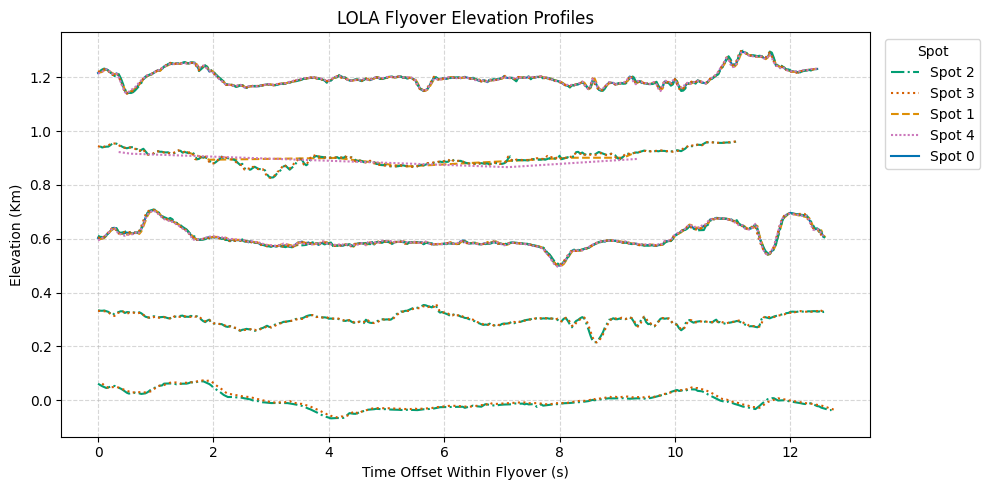

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# --- Prepare LOLA data ---
collection = Sessions.get_extraction_collection("LOLA")
dsk_filename = f"custom_lunar_model_{TIF_SAMPLE_RATE:.4}".replace(".", "_") + ".dsk"
detailed_lunar_model_kernel = DetailedModelDSKKernel(root_path(dsk_filename), tif_sample_rate=TIF_SAMPLE_RATE)
lunar_pit_collection, *_ = Sessions.get_lunar_pit_collections()

# Get pits and compute Cartesian coordinates
pits = lunar_pit_collection.find({}).to_list()
lats, lons = np.array([p['location']['coordinates'][::-1] for p in pits]).T
for pit, location in zip(pits, detailed_lunar_model_kernel.latlon_to_cartesian(lats, lons)):
    pit['safe_name'] = pit['name'].replace(" ", "_")
    pit['location']['cartesian'] = location

# Select target pit
target_pit = next((p for p in pits if p['inner_max_diameter'] == 305), None)
px, py, pz = target_pit['location']['cartesian'] if target_pit else (0, 0, 0)

# Query LOLA shots near the pit
radii = 10
query = {
    "cx_projected": {"$gte": px - radii, "$lte": px + radii},
    "cy_projected": {"$gte": py - radii, "$lte": py + radii},
    "cz_projected": {"$gte": pz - radii, "$lte": pz + radii},
    "SHOT_FLAG": 0
}
results = collection.find(query).to_list()
df = pd.DataFrame.from_records(results)
df['et'] = df['meta'].apply(lambda x: x['et'])
df['range_km'] = df['RANGE'] / 1e6

# Compute surface points
vec_norm = np.linalg.norm(df[['cx_projected', 'cy_projected', 'cz_projected']].values, axis=1)
unit_vec = df[['cx_projected', 'cy_projected', 'cz_projected']].div(vec_norm, axis=0)
df['surface_x'] = df['sc_pos_x'] + unit_vec['cx_projected'] * df['range_km']
df['surface_y'] = df['sc_pos_y'] + unit_vec['cy_projected'] * df['range_km']
df['surface_z'] = df['sc_pos_z'] + unit_vec['cz_projected'] * df['range_km']

def assign_flyover_ids(df, time_column='et', max_gap=1.0):
    df = df.sort_values(by=time_column).reset_index(drop=True).copy()
    time_diffs = np.diff(df[time_column], prepend=df[time_column].iloc[0])
    df['flyover_id'] = np.cumsum(time_diffs > max_gap)
    return df

df = assign_flyover_ids(df)

# --- Build plotting DataFrame ---
records = []
for flyover_id, group in df.groupby('flyover_id'):
    group = group.sort_values(by='et')
    group['et_rel'] = group['et'] - group['et'].min()
    
    for spot, beam_group in group.groupby('spot'):
        range_km = beam_group['RANGE'] / 1e6
        sight_vectors = np.array([
            beam_group["cx_projected"] - beam_group["sc_pos_x"],
            beam_group["cy_projected"] - beam_group["sc_pos_y"],
            beam_group["cz_projected"] - beam_group["sc_pos_z"]
        ])
        vec_norm = np.linalg.norm(sight_vectors, axis=0)
        unit_vec = sight_vectors / vec_norm

        surface_xyz = np.vstack((
            beam_group['sc_pos_x'] + unit_vec[0, :] * range_km.values,
            beam_group['sc_pos_y'] + unit_vec[1, :] * range_km.values,
            beam_group['sc_pos_z'] + unit_vec[2, :] * range_km.values
        )).T
        norms = np.linalg.norm(surface_xyz, axis=1)
        norm_offset = norms - norms.mean()

        for t, z in zip(beam_group['et_rel'], norm_offset):
            records.append({
                'et_rel': t,
                'norm_offset': z,
                'flyover_id': f'Flyover {flyover_id}',
                'spot': f'Spot {spot}'
            })

plot_df = pd.DataFrame(records)

# --- Plotting ---
spot_list = sorted(plot_df['spot'].unique())
colors = sns.color_palette("colorblind", len(spot_list))
linestyles = ['-', '--', '-.', ':', (0, (1, 1))]  # Enough variation
styles = list(itertools.product(colors, linestyles))

style_map = {spot: styles[i % len(styles)] for i, spot in enumerate(spot_list)}

flyovers = sorted(plot_df['flyover_id'].unique())
offset_gap = 0.3

fig, ax = plt.subplots(figsize=(10, 5))
spots = {}
for i, flyover in enumerate(flyovers):
    flyover_data = plot_df[plot_df['flyover_id'] == flyover]
    offset = i * offset_gap

    for spot in spot_list:
        sub = flyover_data[flyover_data['spot'] == spot]
        if sub.empty:
            continue
        color, linestyle = style_map[spot]
        spots[spot] = ax.plot(
            sub['et_rel'],
            sub['norm_offset'] + offset,
            label=spot if i == 0 else None,
            # Hackity hack ...
            color=list(colors)[int(spot[-1])],
            linestyle=linestyle,
            linewidth=1.5
        )[0]

handles, labels = _full_ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(spots.values(), spots.keys(), title="Spot", bbox_to_anchor=(1.01, 1), loc="upper left")

ax.set_xlabel("Time Offset Within Flyover (s)")
ax.set_ylabel("Elevation (Km)")
ax.set_title("LOLA Flyover Elevation Profiles")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig("LOLA_SHOW_PLOT.png", dpi=400, bbox_inches='tight')
print("Saved plot to LOLA_SHOW_PLOT.png")
plt.show()


In [38]:
spot_list

['Spot 0', 'Spot 1', 'Spot 2', 'Spot 3', 'Spot 4']

### Now let's look for Lunar Pits in the data
 - Use proven scipy find_peaks method to find pits (by just reversing values)
 - For edges, use simple differential

In [3]:
import os
import re
import logging
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def detect_pits_from_cartesian(
    df,
    expected_depth_m=30,
    expected_diameter_m=100,
    prominence_factor=0.5,
    min_width_samples=1,
    return_per_flyover=True,
    modes=('pit', 'edge'),  # tuple of modes: 'pit', 'edge'
    edge_width_samples=(1, 3),
):
    """
    Detect pits and/or edges from LOLA Cartesian surface data.

    Parameters:
    - df: DataFrame with 'surface_x/y/z', 'et', and 'flyover_id'
    - modes: one or more of ('pit', 'edge')
    """
    expected_depth_km = expected_depth_m / 1000
    expected_diameter_km = expected_diameter_m / 1000

    results = {} if return_per_flyover else []
    grouped = df.groupby('flyover_id')

    for flyover_id, group in grouped:
        group = group.copy()
        xyz = group[['surface_x', 'surface_y', 'surface_z']].values
        distances = np.linalg.norm(xyz - xyz[0], axis=1)
        group['distance'] = distances
        group = group.sort_values('distance')
        xyz = group[['surface_x', 'surface_y', 'surface_z']].values
        z = np.linalg.norm(xyz, axis=1)
        distances = group['distance'].values

        if len(distances) < 2:
            continue

        sample_spacing = np.mean(np.diff(distances))
        if sample_spacing == 0:
            sample_spacing = 1e-6  # Avoid divide-by-zero

        samples_per_pit = max(min_width_samples, int(expected_diameter_km / sample_spacing))

        all_detections = []

        for mode in modes:
            if mode == 'pit':
                signal = -z
                prom = expected_depth_km * prominence_factor
                peaks, props = find_peaks(
                    signal,
                    prominence=prom,
                    width=(min_width_samples, samples_per_pit)
                )

            elif mode == 'edge':
                delta_z = np.diff(z)
                delta_d = np.diff(distances)
                delta_d[delta_d == 0] = 1e-6
                signal = np.abs(delta_z)
                prom = expected_depth_km * prominence_factor
                peaks, props = find_peaks(
                    signal,
                    prominence=prom,
                    width=edge_width_samples
                )
                peaks = peaks + 1  # Align with original index length after np.diff

            else:
                raise ValueError("Mode must be 'pit', 'edge', or both in a tuple")


            peaks, props = find_peaks(
                signal,
                prominence=prom,
                width=(min_width_samples, samples_per_pit)
            )

            for i, p in enumerate(peaks):
                width_km = props['widths'][i] * sample_spacing
                depth_km = props['prominences'][i]
                steepness = depth_km / width_km if width_km > 0 else 0
                all_detections.append({
                    'index': p,
                    'flyover_id': flyover_id,
                    'distance': distances[p],
                    'z': z[p],
                    'depth_km': depth_km,
                    'width_km': width_km,
                    'steepness': steepness,
                    'prominence_factor': prominence_factor,
                    'mode': mode,
                    'coord_x': xyz[p, 0],
                    'coord_y': xyz[p, 1],
                    'coord_z': xyz[p, 2]
                })

        if return_per_flyover:
            results[flyover_id] = (all_detections, z, distances)
        else:
            results.append((flyover_id, all_detections, z, distances))

    return results


def plot_pit_detections_by_flyover(
    df,
    all_results,
    point=None,
    title_prefix="Detection",
    zoom_km=0.2,
    pit_name="pit",
    save=True,
    pit=None,
    folder='fig'
):
    df = df.copy()
    safe_name = re.sub(r'[^\w\-_\. ]', '_', pit_name.strip().replace(" ", "_"))

    for i, (flyover_id, (detections, z_profile, distances)) in enumerate(all_results.items()):
        if not detections:
            continue

        detections = sorted(detections, key=lambda d: d['steepness'], reverse=True)
        flyover_df = df[df['flyover_id'] == flyover_id].copy()
        xyz = flyover_df[['surface_x', 'surface_y', 'surface_z']].values
        local_dist = np.linalg.norm(xyz - xyz[0], axis=1)
        local_z = np.linalg.norm(xyz, axis=1)

        flyover_df['distance'] = local_dist
        flyover_df = flyover_df.sort_values('distance').reset_index(drop=True)
        xyz = flyover_df[['surface_x', 'surface_y', 'surface_z']].values
        local_z = np.linalg.norm(xyz, axis=1)
        local_dist = flyover_df['distance'].values

        for det_idx, det in enumerate(detections):
            idx = det['index']
            center_dist = local_dist[idx]
            width_km = det['width_km']
            depth_km = det['depth_km']
            steepness = det['steepness']
            prom_factor = det['prominence_factor']
            mode = det.get('mode', 'pit')
            x, y, z = det['coord_x'], det['coord_y'], det['coord_z']

            dist_to_ref_km = np.linalg.norm(np.array([x, y, z]) - pit['location']['cartesian']) if pit['location']['cartesian'] is not None else None
            
            zoom_half_window = zoom_km + width_km / 2
            zoom_mask = (local_dist >= center_dist - zoom_half_window) & (local_dist <= center_dist + zoom_half_window)
            if np.sum(zoom_mask) < 3:
                continue  # Skip if zoom region is too sparse
            sort_idx = np.argsort(local_dist[zoom_mask])

            fig, (ax1, ax2) = plt.subplots(
                1, 2,
                figsize=(13.6, 4),
                sharey=True,
                gridspec_kw={'width_ratios': [7, 3]}
            )

            ax1.plot(local_dist, local_z, label='Elevation Profile')
            ax1.axvline(center_dist, color='red', linestyle='--', label=f'{mode.title()} Center')
            ax1.axvspan(center_dist - width_km / 2, center_dist + width_km / 2, color='red', alpha=0.2, label='Width Estimate')
            dims = (f" | Width [m]:{pit.get('inner_min_diameter')}-{pit.get('inner_max_diameter')};"
                    f"Depth-{pit.get('depth')}" if pit else "")
            ax1.set_title(
                f"{title_prefix} | Flyover {flyover_id} | Mode: {mode.upper()}{dims}\n"
                f"Depth: {depth_km:.3f} km | Width: {width_km:.3f} km | "
                f"Steepness: {steepness:.2f} | Prominence: x{prom_factor:.1f} | "
                f"Dist. to ref: {dist_to_ref_km:.2f} km"
            )
            ax1.set_xlabel("Distance Along Track (km)")
            ax1.set_ylabel("Elevation (km)")
            ax1.grid(True)
            ax1.legend()
            ax1.tick_params(axis='x', which='both', labelbottom=True)

            ax2.plot(local_dist[zoom_mask][sort_idx], local_z[zoom_mask][sort_idx], color='blue', label='Zoomed Region')
            ax2.axvline(center_dist, color='red', linestyle='--')
            ax2.axvspan(center_dist - width_km / 2, center_dist + width_km / 2, color='red', alpha=0.2)
            ax2.set_title(f"Zoomed {mode.title()} Region\n@ ({x:.2f}, {y:.2f}, {z:.2f}) km")
            ax2.set_xlabel("Distance Along Track (km)")
            ax2.set_ylabel("Elevation (km)")
            ax2.grid(True)
            ax2.yaxis.set_visible(True)
            ax2.tick_params(axis='x', labelbottom=True)
            ax2.tick_params(axis='y', labelleft=True)

            plt.tight_layout()

            if save:
                size = pit.get('inner_min_diameter') or pit.get('inner_max_diameter') or 1
                os.makedirs(f"{folder}/{safe_name}", exist_ok=True)
                filename = f"{folder}/{safe_name}/{mode}_{dist_to_ref_km:.2f}_flyover{flyover_id}_det{det_idx}.png"
                plt.savefig(filename)
                plt.close()
            else:
                plt.show()



### Test the functions on a single lunar pit pass

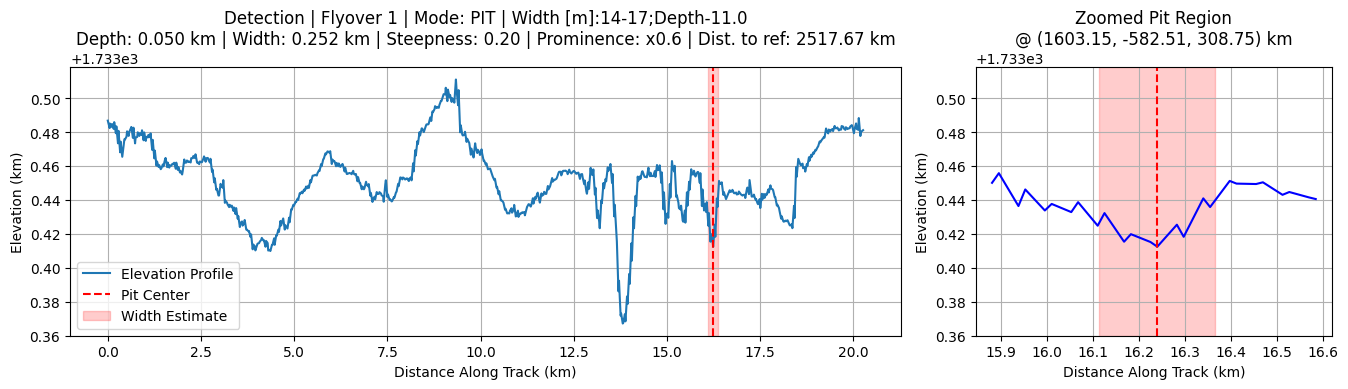

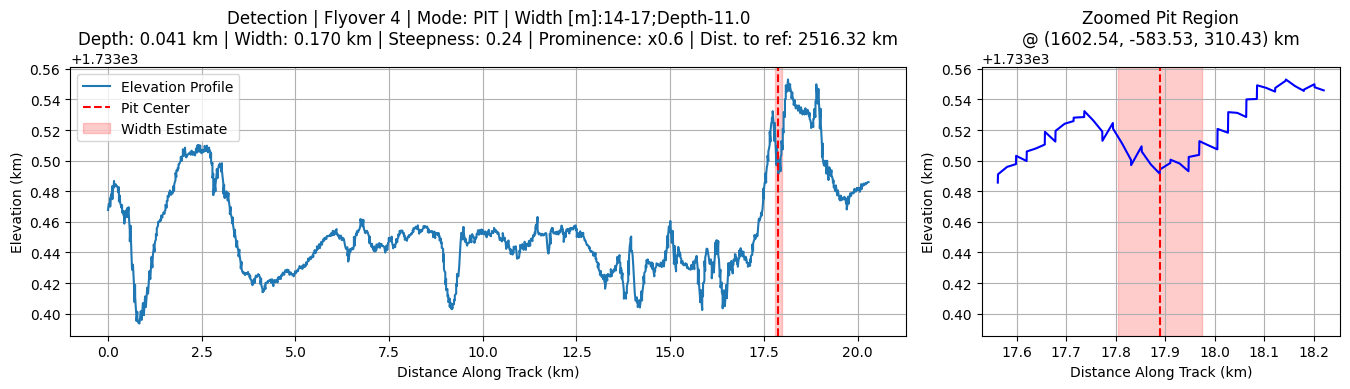

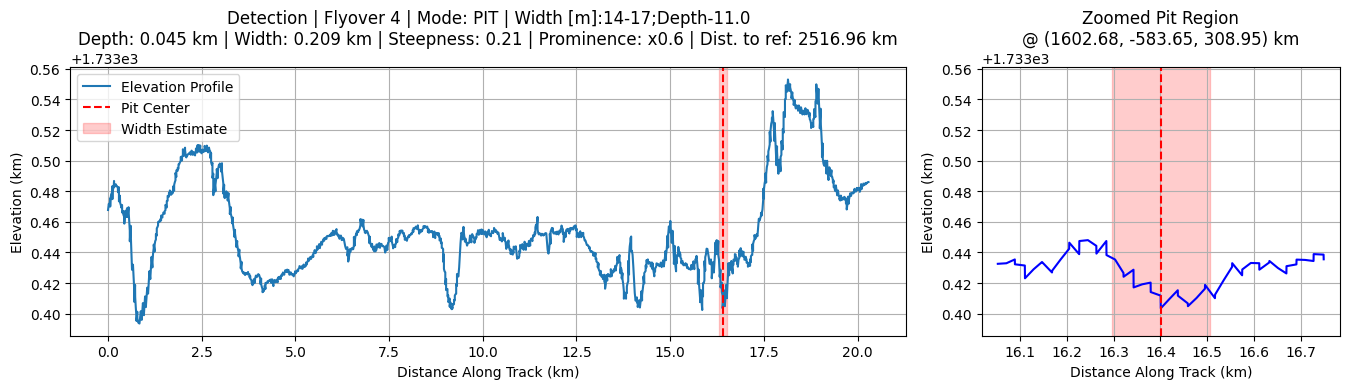

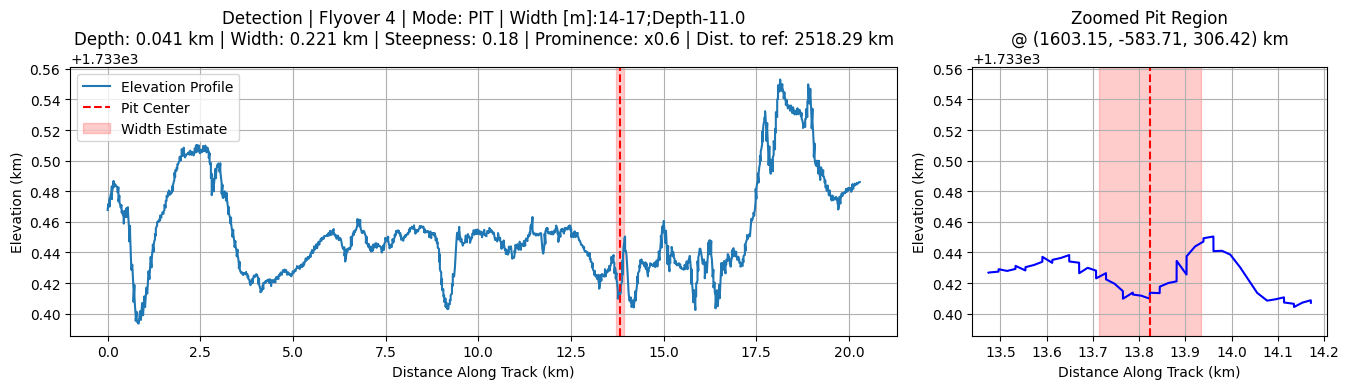

In [5]:
results = detect_pits_from_cartesian(
    df,
    expected_depth_m=65,
    expected_diameter_m=280,
    prominence_factor=0.8,
    edge_width_samples=(1, 5),
    return_per_flyover=True,
    modes=('pit', 'edge')  # detect both
)

plot_pit_detections_by_flyover(df, results, zoom_km=0.25, pit=pit, point=np.array([1602.02398048, -589.30942572, 302.7924745]), pit_name="kokos", save=False)

### Make a proper run of those detections on all pits and all flyovers

In [6]:
from pathlib import Path

def process_pit(pit, collection, radius_km=10):

    px, py, pz = pit['location']['cartesian']
    
    query = {
        "cx_projected": {"$gte": px - radius_km, "$lte": px + radius_km},
        "cy_projected": {"$gte": py - radius_km, "$lte": py + radius_km},
        "cz_projected": {"$gte": pz - radius_km, "$lte": pz + radius_km},
        "SHOT_FLAG": 0
    }
    results = collection.find(query).to_list()
    if not results:
        return None  # No data

    df = pd.DataFrame.from_records(results)
    df['et'] = df['meta'].apply(lambda x: x['et'])
    df['range_km'] = df['RANGE'] / 1e6

    sight_vectors = np.array([
        df["cx_projected"] - df["sc_pos_x"],
        df["cy_projected"] - df["sc_pos_y"],
        df["cz_projected"] - df["sc_pos_z"]
    ])
    vec_norm = np.linalg.norm(sight_vectors, axis=0)
    unit_vec = sight_vectors / vec_norm

    df['surface_x'] = df['sc_pos_x'] + unit_vec[0, :] * df['range_km']
    df['surface_y'] = df['sc_pos_y'] + unit_vec[1, :] * df['range_km']
    df['surface_z'] = df['sc_pos_z'] + unit_vec[2, :] * df['range_km']

    df = assign_flyover_ids(df)

    return df

def assign_flyover_ids(df, time_column='et', max_gap=1.0):
    df = df.sort_values(by=time_column).reset_index(drop=True).copy()
    time_diffs = np.diff(df[time_column], prepend=df[time_column].iloc[0])
    df['flyover_id'] = np.cumsum(time_diffs > max_gap)
    return df

In [44]:
collection = Sessions.get_extraction_collection("LOLA")
dsk_filename = f"custom_lunar_model_{TIF_SAMPLE_RATE:.4}".replace(".", "_") + ".dsk"
detailed_lunar_model_kernel = DetailedModelDSKKernel(root_path(dsk_filename), tif_sample_rate=TIF_SAMPLE_RATE)
lunar_pit_collection, lunar_pit_details_collection, lunar_pit_images_collection = Sessions.get_lunar_pit_collections()
# Get pits and compute cartesian locations
pits = lunar_pit_collection.find({}).to_list()
lats, lons = np.array([p['location']['coordinates'][::-1] for p in pits]).T
for pit, location in zip(pits, detailed_lunar_model_kernel.latlon_to_cartesian(lats, lons)):
    pit['safe_name'] = pit['name'].replace(" ", "_")
    pit['location']['cartesian'] = location


In [51]:
from tqdm.notebook import tqdm
import multiprocessing as mp
import numpy as np

def process_and_plot_pit(args):
    pit, folder, radius_km = args
    from tqdm.notebook import tqdm  # Ensure tqdm is imported in subprocess
    try:
        collection = Sessions.get_extraction_collection("LOLA")
        df = process_pit(pit, collection, radius_km=radius_km)
        if df is None or df.empty:
            tqdm.write(f"[{pit['name']}] - No data")
            return pit['name'], 0

        diameter = np.mean([pit.get(k) for k in ["funnel_max_diameter", "funnel_min_diameter"] if pit.get(k)])
        if diameter:
            results = detect_pits_from_cartesian(
                df,
                expected_depth_m=pit['depth'],
                expected_diameter_m=diameter,
                prominence_factor=0.8,
                edge_width_samples=(1, 4),
                modes=('pit', 'edge')
            )
            plot_pit_detections_by_flyover(
                df, results,
                point=pit['location']['cartesian'],
                pit_name=pit["name"],
                save=True,
                pit=pit,
                folder=folder
            )
            tqdm.write(f"[{pit['name']}] - Done ({len(results)} flyovers)")
            return pit['name'], len(results), df['flyover_id'].max() if not df.empty else None
    except Exception as e:
        tqdm.write(f"[{pit['name']}] - ERROR: {e}")
        return pit['name'], f"ERROR: {e}"

    return pit['name'], 0, df['flyover_id'].max() if not df.empty else None

def run_parallel_pit_detection(pits, folder, workers=16, radius_km=1):
    ctx = mp.get_context("fork")  # Use 'fork' for Jupyter compatibility
    args_iterable = [(pit, folder, radius_km) for pit in pits]
    with ctx.Pool(processes=workers) as pool:
        results = list(tqdm(
            pool.imap_unordered(process_and_plot_pit, args_iterable),
            total=len(pits),
            desc="Looking for lunar pits",
            ncols=1000
        ))
    return results


# Run the detection with multiple configurations, evaluate manually

In [ ]:
run_parallel_pit_detection(pits, "figs1km", radius_km=1)
run_parallel_pit_detection(pits, "figs", radius_km=10)
run_parallel_pit_detection(pits, "figs300m", radius_km=0.3)

In [52]:
results1 = run_parallel_pit_detection(pits, "figs10", radius_km=10)
results2 = run_parallel_pit_detection(pits, "figs1", radius_km=1)

/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/pymongo/_csot.py:119: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://www.mongodb.com/docs/languages/python/pymongo-driver/current/faq/#is-pymongo-fork-safe-
  return func(self, *args, **kwargs)
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/pymongo/_csot.py:119: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://www.mongodb.com/docs/languages/python/pymongo-driver/current/faq/#is-pymongo-fork-safe-
  return func(self, *args, **kwargs)
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/pymongo/_csot.py:119: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://www.mongodb.com/docs/lan

Looking for lunar pits:   0%|                                                                                 …

/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/pymongo/_csot.py:119: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://www.mongodb.com/docs/languages/python/pymongo-driver/current/faq/#is-pymongo-fork-safe-
  return func(self, *args, **kwargs)
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/pymongo/_csot.py:119: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://www.mongodb.com/docs/languages/python/pymongo-driver/current/faq/#is-pymongo-fork-safe-
  return func(self, *args, **kwargs)
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/pymongo/_csot.py:119: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://www.mongodb.com/docs/lan

[Aristarchus 2a] - Done (12 flyovers)
[Aristarchus 5] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Aristarchus 6] - Done (14 flyovers)
[Aristarchus 2b] - Done (12 flyovers)
[Aristarchus 3b] - Done (13 flyovers)
[Aristarchus 7a] - Done (14 flyovers)
[Aristillus 1] - Done (12 flyovers)
[Catalán B 1] - Done (34 flyovers)
[Adams B 2] - Done (26 flyovers)
[Adams B 1] - Done (26 flyovers)
[Copernicus 10] - Done (5 flyovers)
[Compton Pit] - Done (7 flyovers)
[Central Mare Fecunditatis Pit] - Done (5 flyovers)
[Aristillus 2] - Done (11 flyovers)
[Aristillus 4] - Done (12 flyovers)
[Copernicus 14] - Done (7 flyovers)
[Copernicus 13a] - Done (7 flyovers)
[Copernicus 17a] - Done (7 flyovers)
[Copernicus 12] - Done (6 flyovers)
[Copernicus 17b] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Copernicus 19a] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Copernicus 18] - Done (7 flyovers)
[Copernicus 16] - Done (11 flyovers)
[Copernicus 19b]

/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Das 1a] - ERROR: cannot convert float NaN to integer
[Das 1b] - Done (11 flyovers)
[Das 2] - Done (13 flyovers)
[Das 3] - Done (14 flyovers)
[Aristarchus 4] - Done (13 flyovers)
[Crookes 6] - Done (15 flyovers)
[Das 4b] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Das 4c] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Das 4d] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Das 4e] - Done (12 flyovers)
[Aristarchus 8] - Done (13 flyovers)
[Aristarchus 9] - Done (12 flyovers)
[Aristarchus 3c] - Done (13 flyovers)
[Dollond E 1a] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Dollond E 1c] - Done (41 flyovers)
[Dollond E 1b] - Done (41 flyovers)
[Dollond E 1d] - Done (41 flyovers)
[Copernicus 3] - Done (6 flyovers)
[Fraunhofer G 1] - Done (45 flyovers)
[Highland 1] - Done (17 flyovers)
[Hayn 1] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Das 4a] - Done (12 flyovers)
[Highland 3] - Done (14 f

/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Jackson 2b] - ERROR: cannot convert float NaN to integer
[Jackson 1a] - Done (6 flyovers)
[Crookes 7] - Done (16 flyovers)
[Jackson 1b] - Done (6 flyovers)
[Jackson 4] - Done (15 flyovers)
[Jackson 5] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Jackson 6] - Done (10 flyovers)
[Kepler 2] - Done (14 flyovers)
[Kepler 3] - Done (15 flyovers)
[Crookes 5b] - Done (17 flyovers)
[Jackson 1c] - Done (6 flyovers)
[King 10] - Done (19 flyovers)
[Crookes 1] - Done (18 flyovers)
[Kepler 4a] - Done (13 flyovers)
[King 11b] - Done (18 flyovers)
[Jackson 3] - Done (17 flyovers)
[King 13b] - Done (17 flyovers)
[King 15a] - Done (14 flyovers)
[Jackson 2a] - Done (6 flyovers)
[King 15b] - Done (14 flyovers)
[Crookes 9] - Done (17 flyovers)
[King 18] - Done (19 flyovers)
[Crookes 5a] - Done (17 flyovers)
[King 17] - Done (20 flyovers)
[King 11a] - Done (18 flyovers)
[King 19] - Done (19 flyovers)
[King 16] - Done (22 flyovers)
[King 20c] - ERROR: unsupported operand type(s) for /: 

/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


[Southwest Mare Tranquillitatis Pit] - Done (8 flyovers)


/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Southwest Mare Tranquillitatis B Pit] - ERROR: cannot convert float NaN to integer
[Oday 2] - Done (17 flyovers)
[King 36] - Done (16 flyovers)
[Southwest Mare Fecunditatis Pit] - Done (3 flyovers)
[Stevinus 10] - Done (30 flyovers)
[Stevinus 13] - Done (44 flyovers)
[Stevinus 11] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Stevinus 14a] - Done (51 flyovers)
[Stevinus 14b] - Done (51 flyovers)
[Stevinus 17] - Done (45 flyovers)
[Stevinus 1] - Done (46 flyovers)
[King 4a] - Done (15 flyovers)
[Stevinus 18] - Done (47 flyovers)
[King 35] - Done (16 flyovers)
[Stevinus 19] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Stevinus 2] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Stevinus 23] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Stevinus 24] - Done (42 flyovers)
[Stefan L 2] - Done (21 flyovers)
[Stevinus 26] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Stevinus 25] - Done (46 flyov

/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Stevinus 9b] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Stevinus 8] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'


/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Tharp 1b] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Stevinus 22] - Done (33 flyovers)
[Stevinus 12] - Done (50 flyovers)
[Tycho 14] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Stevinus 3] - Done (40 flyovers)
[Tycho 15a] - Done (20 flyovers)
[Rutherfurd 3] - Done (76 flyovers)
[Tycho 15b] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Palitzsch B 1] - Done (20 flyovers)
[Tycho 19] - Done (24 flyovers)
[Tharp 2] - Done (28 flyovers)
[Tharp 4] - Done (28 flyovers)
[Tycho 2] - Done (48 flyovers)
[Tycho 29a] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Tharp 1a] - Done (29 flyovers)
[Tharp 5] - Done (28 flyovers)
[Tycho 29b] - Done (39 flyovers)
[Tycho 3] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[King 9a] - Done (18 flyovers)
[Tycho 12] - Done (19 flyovers)
[Tycho 18] - Done (37 flyovers)
[Tycho 5e] - Done (34 flyovers)
[Tycho 7] - ERROR: unsupported operand type(s) for /: 'NoneTy

/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/pymongo/_csot.py:119: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://www.mongodb.com/docs/languages/python/pymongo-driver/current/faq/#is-pymongo-fork-safe-
  return func(self, *args, **kwargs)
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/pymongo/_csot.py:119: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://www.mongodb.com/docs/languages/python/pymongo-driver/current/faq/#is-pymongo-fork-safe-
  return func(self, *args, **kwargs)
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/pymongo/_csot.py:119: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://www.mongodb.com/docs/lan

Looking for lunar pits:   0%|                                                                                 …

/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/pymongo/_csot.py:119: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://www.mongodb.com/docs/languages/python/pymongo-driver/current/faq/#is-pymongo-fork-safe-
  return func(self, *args, **kwargs)
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/pymongo/_csot.py:119: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://www.mongodb.com/docs/languages/python/pymongo-driver/current/faq/#is-pymongo-fork-safe-
  return func(self, *args, **kwargs)
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/pymongo/_csot.py:119: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://www.mongodb.com/docs/lan

[Aristarchus 5] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Aristarchus 3b] - Done (1 flyovers)
[Aristarchus 3c] - Done (1 flyovers)
[Aristarchus 3a] - Done (1 flyovers)
[Aristarchus 8] - Done (3 flyovers)
[Aristarchus 4] - Done (3 flyovers)
[Aristarchus 7a] - Done (3 flyovers)
[Aristarchus 7b] - Done (3 flyovers)
[Aristarchus 2a] - Done (4 flyovers)
[Aristarchus 2b] - Done (4 flyovers)
[Aristarchus 6] - Done (1 flyovers)
[Aristarchus 1] - Done (4 flyovers)
[Catalán B 1] - Done (2 flyovers)
[Aristarchus 2c] - Done (4 flyovers)
[Copernicus 11] - ERROR: 'tuple' object has no attribute 'empty'
[Copernicus 1] - ERROR: 'tuple' object has no attribute 'empty'
[Copernicus 12] - ERROR: 'tuple' object has no attribute 'empty'
[Copernicus 10] - Done (2 flyovers)
[Aristarchus 9] - Done (4 flyovers)
[Aristillus 2] - Done (2 flyovers)
[Aristillus 3] - Done (1 flyovers)
[Aristillus 4] - Done (2 flyovers)
[Copernicus 13a] - ERROR: 'tuple' object has no attribute 'empty'
[Coperni

/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Das 1a] - ERROR: cannot convert float NaN to integer
[Crookes 10] - ERROR: 'tuple' object has no attribute 'empty'
[Adams B 3] - Done (3 flyovers)
[Crookes 2] - Done (1 flyovers)
[Crookes 4] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Crookes 5a] - Done (1 flyovers)
[Das 1b] - Done (3 flyovers)
[Crookes 5b] - Done (1 flyovers)
[Crookes 5c] - Done (1 flyovers)
[Crookes 9] - ERROR: 'tuple' object has no attribute 'empty'
[Crookes 3] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Crookes 6] - Done (1 flyovers)
[Crookes 5d] - Done (1 flyovers)
[Crookes 7] - Done (1 flyovers)
[Das 2] - ERROR: 'tuple' object has no attribute 'empty'
[Das 3] - ERROR: 'tuple' object has no attribute 'empty'
[Das 4e] - Done (1 flyovers)
[Das 4a] - Done (1 flyovers)
[Das 4d] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Das 4b] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Das 4c] - ERROR: unsupported operand type(s) for /: 'NoneTy

/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Southwest Mare Tranquillitatis B Pit] - ERROR: cannot convert float NaN to integer
[Southwest Mare Tranquillitatis Pit] - Done (1 flyovers)
[Runge Pit] - Done (2 flyovers)
[Southwest Mare Fecunditatis Pit] - Done (1 flyovers)
[Stevinus 1] - Done (5 flyovers)
[Stevinus 12] - Done (1 flyovers)
[Stevinus 11] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Stevinus 13] - Done (5 flyovers)
[Stevinus 10] - Done (2 flyovers)
[Stevinus 14b] - Done (1 flyovers)
[Stevinus 14a] - Done (1 flyovers)
[Stevinus 17] - Done (4 flyovers)
[Stevinus 15] - Done (3 flyovers)
[Stevinus 18] - Done (0 flyovers)
[Stevinus 16] - Done (7 flyovers)
[Stevinus 2] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Stevinus 19] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Stevinus 24] - Done (1 flyovers)
[Stevinus 22] - Done (2 flyovers)
[Stevinus 23] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Stevinus 25] - Done (2 flyovers)
[Stevinus 3] - 

/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Stevinus 9b] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Tharp 1a] - Done (1 flyovers)
[Stevinus 6] - Done (4 flyovers)
[Tharp 2] - Done (1 flyovers)


/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/goal-admin/anaconda3/envs/lts-3.9-prod/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[Tharp 1b] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Tycho 12] - ERROR: 'tuple' object has no attribute 'empty'
[Tharp 5] - ERROR: 'tuple' object has no attribute 'empty'
[Tharp 4] - ERROR: 'tuple' object has no attribute 'empty'
[Tycho 13] - Done (3 flyovers)
[Tycho 15a] - Done (2 flyovers)
[Tharp 3] - Done (3 flyovers)
[Tycho 2] - ERROR: 'tuple' object has no attribute 'empty'
[Tycho 15b] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Tycho 18] - Done (3 flyovers)
[Tycho 14] - ERROR: 'tuple' object has no attribute 'empty'
[Tycho 17a] - Done (4 flyovers)
[Tycho 16] - Done (1 flyovers)
[Tycho 29a] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Tycho 19] - Done (2 flyovers)
[Tycho 29b] - Done (4 flyovers)
[West Marius Hills Pit] - Done (2 flyovers)
[Tycho 17b] - Done (4 flyovers)
[Tycho 3] - ERROR: unsupported operand type(s) for /: 'NoneType' and 'int'
[Tycho 5a] - Done (6 flyovers)
[Wood T 1b] - Done (2 flyovers)
[Wood T 1

# Compute statistics about the data

In [45]:
# Count documents where SHOT_FLAG is 0
count_zero = collection.count_documents({"SHOT_FLAG": 0})
# Count documents where SHOT_FLAG is not 0 (or missing)
count_nonzero = collection.count_documents({"SHOT_FLAG": {"$ne": 0}})
print("Zero count: ", count_zero)
print("Nonzero count: ", count_nonzero)